## 1. Import Libraries

In [1]:
# OS environment
import os

# Import SparkConf class into program
from pyspark import SparkConf

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# PySpark Data Operations
from pyspark.sql.functions import col, count, size, split, udf
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Regex
import re

# Plotting graphs
import matplotlib.pyplot as plt

# Numeric operations
import numpy as np

## 2. Configure Spark Environment
Using the code snippets from tutorial 1 and 2, set up the Spark environment and configure the Spark Application using SparkConf.

In [2]:
spark_home = os.environ.get("SPARK_HOME")

if spark_home:
    print(f"SPARK_HOME: {spark_home}")
else:
    print("SPARK_HOME environement variable is not set.")

os.environ["SPARK_HOME"]= "/usr/local/lib/python3.10/dist-packages/pyspark"

print (f"SPARK_HOME is now set to: {os.environ.get('SPARK_HOME')}")

SPARK_HOME: /usr/local/lib/python3.8/dist-packages/pyspark
SPARK_HOME is now set to: /usr/local/lib/python3.10/dist-packages/pyspark


In [3]:
# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "WELFake Exploratory Data Anlaysis (EDA)"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Setup SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

25/08/07 07:12:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## 3. Load Datasets
Load the WELFake dataset into a Spark DataFrame by reading a CSV file (WELFake_Dataset.csv). It handles multi-line text in the text and title columns and treats " as the escape character for the texts.

In [4]:
# Load dataset into Spark dataframe
welfake_df = spark.read.csv(
    "WELFake_Dataset.csv",
    header=True,
    inferSchema=True,
    quote='"', 
    multiLine=True, #multilines in text and title data
    escape='"'
)

# Display sample rows
welfake_df.show(3, truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
# Rename first column as index
welfake_df = welfake_df.withColumnRenamed("_c0", "index")

# Show dataframe dimensions
num_rows = welfake_df.count()
num_cols = len(welfake_df.columns)

print(f"Rows: {num_rows}")
print(f"Columns: {num_cols}")

print("Columns and Types:", dict(welfake_df.dtypes))

Rows: 72134
Columns: 4
Columns and Types: {'index': 'int', 'title': 'string', 'text': 'string', 'label': 'int'}


## 4. Remove duplicates
Check and remove any duplicate news by referring to the title and text.

In [6]:
# Count original dataset rows
original_count = welfake_df.count()

# Remove duplicate news articles
welfake_df_dedup = welfake_df.dropDuplicates(["title", "text"])

deduped_count = welfake_df_dedup.count()
duplicates_removed = original_count - deduped_count

print(f"Original rows: {original_count}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"After dataset size: {deduped_count} rows")

Original rows: 72134
Duplicates removed: 8456
After dataset size: 63678 rows


## 5. Clean article title and text data
Remove the following elements from the text to extract only the actual text contents of the news. Although it is to be noted that the following cleaning process may change in the Phase 2 of the project.

In [7]:
# Define text cleaning function
def clean_text(text):
    
    """
    Clean the input text string by removing unwanted elements while keeping useful punctuation.

    Steps performed:
    - Remove URLs (e.g. http://..., www...)
    - Remove Twitter-style mentions (@username) and hashtags (#hashtag)
    - Remove HTML entities (e.g. &nbsp;)
    - Remove emojis and non-ASCII characters
    - Remove special characters (excluding common punctuation: . , ! ? ; : ` ’ - ')
    - Normalize whitespace (convert multiple spaces/tabs/newlines into a single space)
    - Trim leading and trailing spaces

    Args:
        text (str or None): The input text to clean.

    Returns:
        str: A cleaned version of the input text. If input is None, returns an empty string.
    """
    
    if text is None:
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove HTMLs
    text = re.sub(r'&\w+;', '', text)
    
    # Remove emojis and other non-ASCII symbols
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove special characters but keep punctuation (.,!?';:’)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?;:\`\'-]', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Register UDF
clean_text_udf = udf(clean_text, StringType())

The cleaned texts and titles are saved in new columns called "cleaned_text" and "cleaned_title" respectively.

In [8]:
# Apply cleaning to title and text
welfake_df_clean = welfake_df_dedup.withColumn("cleaned_title", clean_text_udf("title")) \
                       .withColumn("cleaned_text", clean_text_udf("text"))

# Preview results
welfake_df_clean.select("title", "cleaned_title", "text", "cleaned_text").show(5, truncate=80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                           title|                                                                   cleaned_title|                                                                            text|                                                                    cleaned_text|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|Credit Suisse Boss Fa

## 6. Remove empty values in text and title
Rremove the rows with empty values (e.g. empty strings, null) in the cleaned_text, cleaned_title and label.

In [9]:
# Remove null or empty string values
welfake_df_processed = welfake_df_clean.filter(
    (col("cleaned_text").isNotNull()) & 
    (col("cleaned_text") != "") &
    (col("cleaned_title").isNotNull()) & 
    (col("cleaned_title") != "") &
    (col("label").isNotNull()) 
)

# Count the number of rows with empty values removed
processed_count = welfake_df_processed.count()
removed_empty = deduped_count - processed_count

print(f"Removed empty text rows: {removed_empty}")
print(f"After dataset size: {processed_count} rows")


Removed empty text rows: 1216
After dataset size: 62462 rows


## 7. Check label class distribution (0: real, 1: fake)

In [10]:
# Aggregate label count
label_distribution = welfake_df_processed.groupBy("label").agg(count("*").alias("count"))

The distribution of real versus fake news articles was approximately 55% for real news and 45% for fake news, which is fairly balanced.

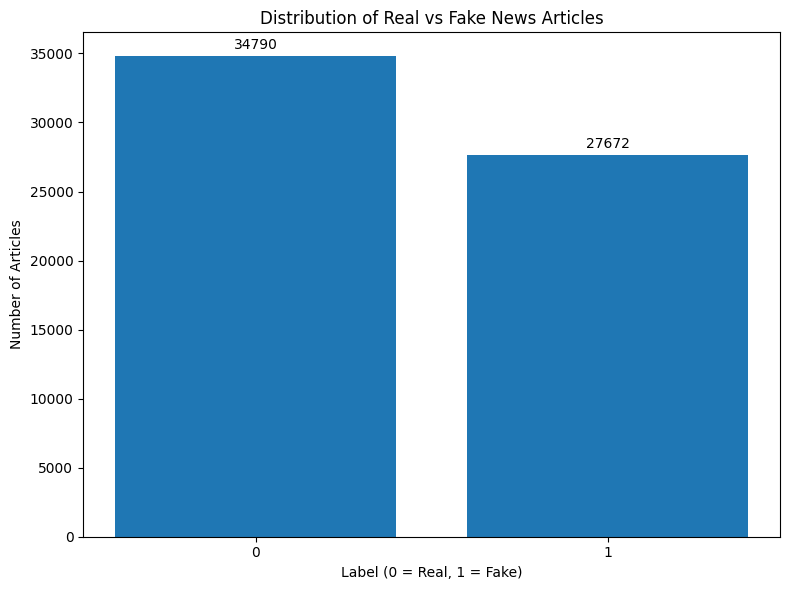

In [11]:
# Convert to pandas
label_dist_pd = label_distribution.toPandas()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(label_dist_pd["label"], label_dist_pd["count"])

# Labels and title
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Real vs Fake News Articles")

# Add values on top of bars
for i, count in enumerate(label_dist_pd["count"]):
    plt.text(label_dist_pd["label"][i], count + 500, count, ha='center')

plt.xticks([0, 1])
plt.tight_layout()
plt.show()

## 8. Calculate article title and text word counts
We calculated the word count of the cleaned titles and texts to analyze the distribution of word counts for both real and fake news. This helps us identify any patterns that may distinguish the two, as well as detect any outliers based on the text word count.

In [12]:
# Calculate title word count
welfake_df_wc = welfake_df_processed.withColumn("title_wc", size(split(col("cleaned_title"), "\\s+")))

# Calculate text word count
welfake_df_wc = welfake_df_wc.withColumn("text_wc", size(split(col("cleaned_text"), "\\s+")))

welfake_df_wc.select("cleaned_title", "title_wc", "cleaned_text", "text_wc").show(3)

+--------------------+--------+--------------------+-------+
|       cleaned_title|title_wc|        cleaned_text|text_wc|
+--------------------+--------+--------------------+-------+
|Credit Suisse Bos...|      15|When Tidjane Thia...|   1493|
|Angry and inspire...|       9|ROCKVILLE, Md. Re...|    841|
|Russian Economy M...|      15|This post was ori...|    751|
+--------------------+--------+--------------------+-------+
only showing top 3 rows



Based on the histograms and the statistics of the real and fake news, there seems to be outliers present in both labels.

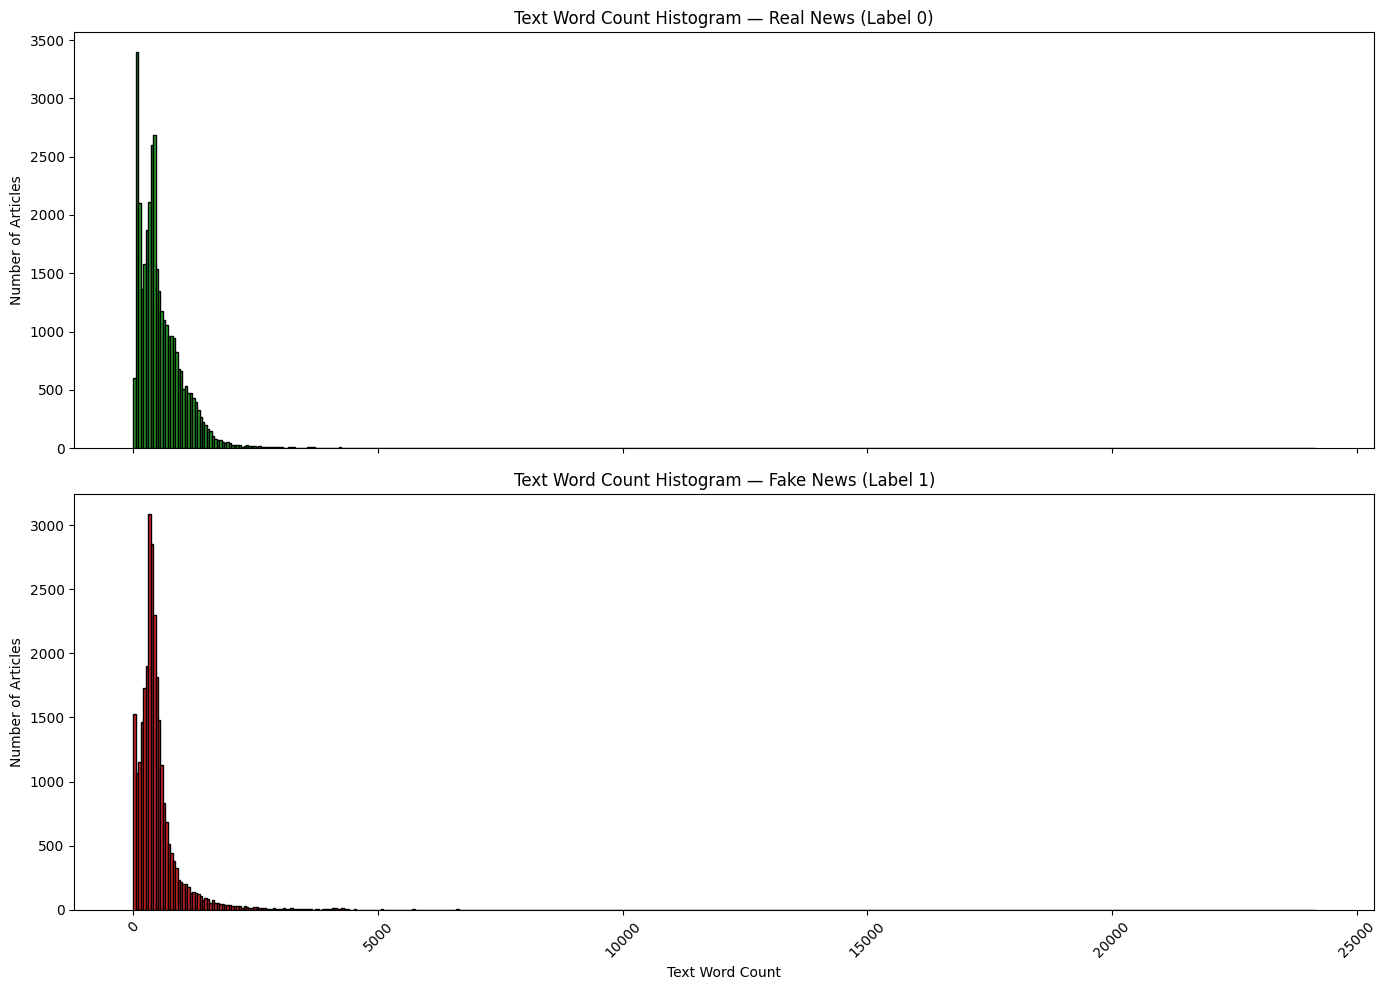

In [13]:
# Select relevant columns
welfake_df_text = welfake_df_wc.select("label", "text_wc")
welfake_text_pd = welfake_df_text.toPandas()

# Separate word counts based on label
real_text_wc = welfake_text_pd[welfake_text_pd["label"] == 0]["text_wc"]
fake_text_wc = welfake_text_pd[welfake_text_pd["label"] == 1]["text_wc"]

# Define bins (adjust step size if needed)
bin_edges = np.arange(0, max(welfake_text_pd["text_wc"]) + 50, 50)

# Step 4: Plot two histograms (one for each label)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Real news histogram
axes[0].hist(real_text_wc, bins=bin_edges, color="tab:green", edgecolor="black")
axes[0].set_title("Text Word Count Histogram — Real News (Label 0)")
axes[0].set_ylabel("Number of Articles")

# Fake news histogram
axes[1].hist(fake_text_wc, bins=bin_edges, color="tab:red", edgecolor="black")
axes[1].set_title("Text Word Count Histogram — Fake News (Label 1)")
axes[1].set_xlabel("Text Word Count")
axes[1].set_ylabel("Number of Articles")

# Make y-axis limits consistent for visual comparison
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [14]:
# Real news (label = 0)
print("Real News (label = 0) Text Statistics:")
welfake_df_wc.filter(col("label") == 0).select("text_wc").describe().show()

# Fake news (label = 1)
print("Fake News (label = 1) Text Statistics:")
welfake_df_wc.filter(col("label") == 1).select("text_wc").describe().show()

Real News (label = 0) Text Statistics:


+-------+-----------------+
|summary|          text_wc|
+-------+-----------------+
|  count|            34790|
|   mean|574.4800804828974|
| stddev|558.6565373010758|
|    min|                1|
|    max|            14439|
+-------+-----------------+

Fake News (label = 1) Text Statistics:


+-------+-----------------+
|summary|          text_wc|
+-------+-----------------+
|  count|            27672|
|   mean|514.0551821335646|
| stddev|652.3799562133014|
|    min|                1|
|    max|            24134|
+-------+-----------------+



## 9. Remove outliers based on text word count
To identify the outliers, we first checked the quantile values, and found that there are a huge jump of value from the 98th (1323) to 99th (24134) percentile. On the other hand, the lower tail percentile of 1th (1) and 2th (26) also has a moderate difference.

In [15]:
# Step 2: Calculate key percentiles for text word count
percentiles_main = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
percentiles_upper_tail = [0.96, 0.97, 0.98, 0.99]
percentiles_lower_tail = [0.01, 0.02, 0.03, 0.04]

# Compute percentiles
main_quantiles = welfake_df_wc.approxQuantile("text_wc", percentiles_main, 0.01)
upper_tail_quantiles = welfake_df_wc.approxQuantile("text_wc", percentiles_upper_tail, 0.01)
lower_tail_quantiles = welfake_df_wc.approxQuantile("text_wc", percentiles_lower_tail, 0.01)

# Show quantile values for analysis
print(f"Main quantiles (1% to 99%): {main_quantiles}")
print(f"Upper tail (96% to 99%): {upper_tail_quantiles}")
print(f"Lower tail (1% to 4%): {lower_tail_quantiles}")

Main quantiles (1% to 99%): [1.0, 63.0, 94.0, 241.0, 402.0, 663.0, 1062.0, 1323.0, 24134.0]
Upper tail (96% to 99%): [1402.0, 1509.0, 1675.0, 24134.0]
Lower tail (1% to 4%): [1.0, 26.0, 39.0, 54.0]


Based on the observed difference and the fact that one word news texts should not be possible, we consider them as outliers and remove them from the dataset.

In [16]:
# Show label counts before removing outlier
print("Label counts BEFORE filtering:")
welfake_df_wc.groupBy("label").count().orderBy("label").show()

# Calculate 2nd and 98th percentiles
lower_bound, upper_bound = welfake_df_wc.approxQuantile("text_wc", [0.02, 0.98], 0.01)

print(f"Filter out text_wc < {lower_bound} or > {upper_bound}\n")

# Filter out values below the 2nd and above the 98th percentiles
welfake_df_filtered = welfake_df_wc.filter(
    (F.col("text_wc") > lower_bound) & (F.col("text_wc") < upper_bound)
)

# Show label counts after removing outliers
print("Label counts AFTER filtering:")
welfake_df_filtered.groupBy("label").count().orderBy("label").show()

Label counts BEFORE filtering:


+-----+-----+
|label|count|
+-----+-----+
|    0|34790|
|    1|27672|
+-----+-----+



Filter out text_wc < 26.0 or > 1675.0

Label counts AFTER filtering:


+-----+-----+
|label|count|
+-----+-----+
|    0|33662|
|    1|25932|
+-----+-----+



## 10. Plot text word count histogram per label (after preprocessing)
Plot the new text word count histograms after removing the outliers.

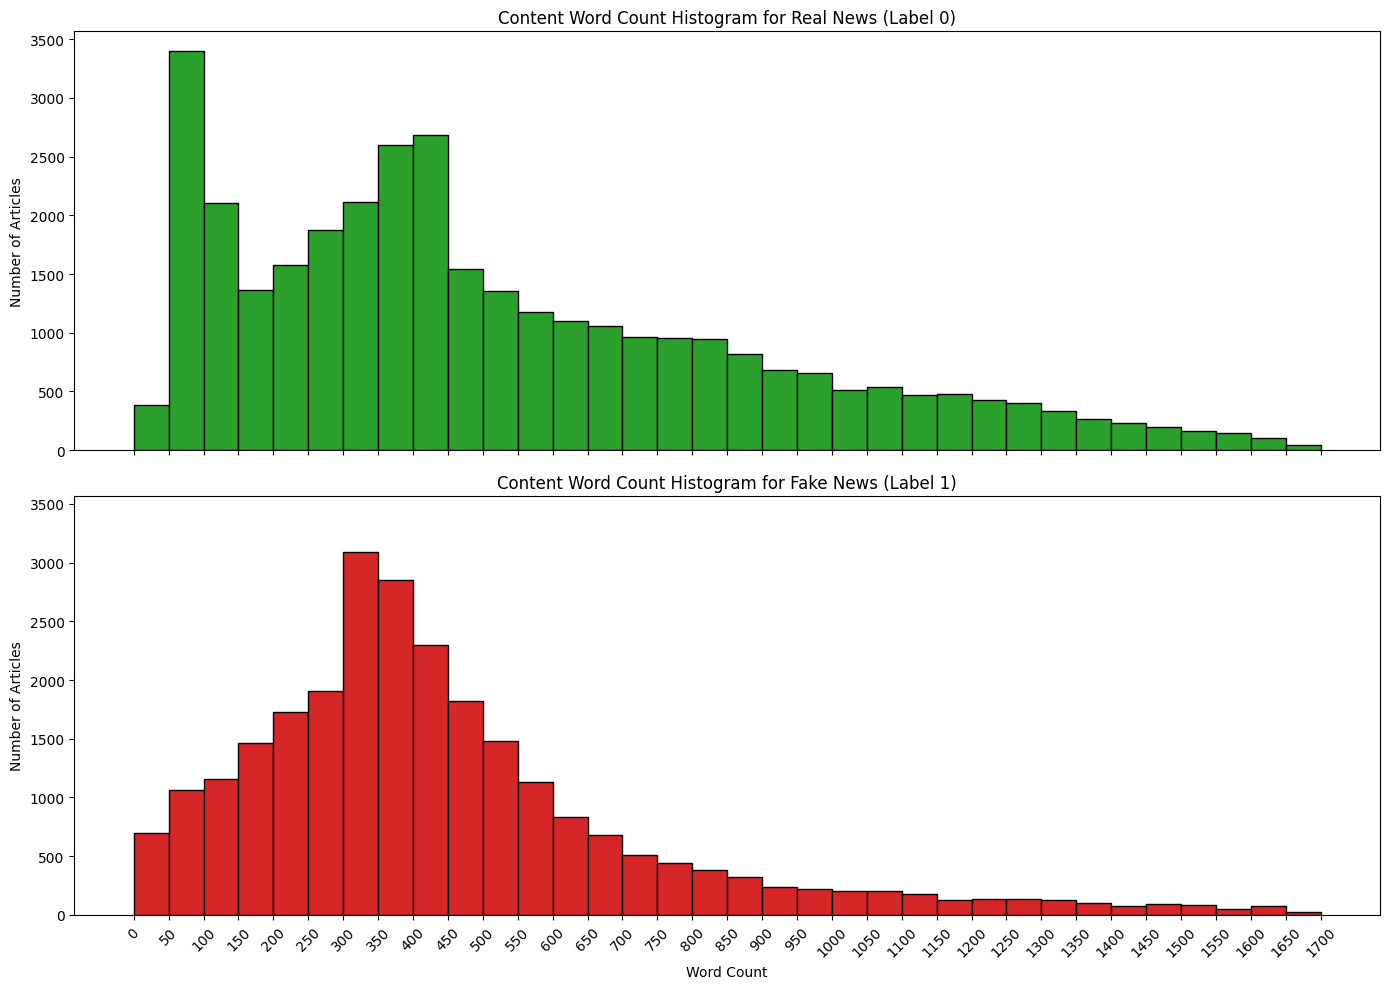

In [17]:
# Convert PySpark dataframe to pandas
welfake_df_text = welfake_df_filtered.select("label", "text_wc")
welfake_text_pd = welfake_df_text.toPandas()

# Separate data by label
real_text_wc = welfake_text_pd[welfake_text_pd["label"] == 0]["text_wc"]
fake_text_wc = welfake_text_pd[welfake_text_pd["label"] == 1]["text_wc"]

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

bin_edges = np.arange(0, max(welfake_text_pd["text_wc"]) + 50, 50)

# Real news histogram
n, bins, patches = axes[0].hist(real_text_wc, bins=bin_edges, color="tab:green", edgecolor="black")
axes[0].set_title("Content Word Count Histogram for Real News (Label 0)")
axes[1].set_xlabel("Word Count")
axes[0].set_ylabel("Number of Articles")

# Fake news histogram
n, bins, patches = axes[1].hist(fake_text_wc, bins=bin_edges, color="tab:red", edgecolor="black")
axes[1].set_title("Content Word Count Histogram for Fake News (Label 1)")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Number of Articles")

# Set same y-axis limits for better visual comparison
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

# Set x-ticks to the bin edges
for ax in axes:
    ax.set_xticks(bins)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()


In [18]:
# Real news (label = 0)
print("Real News (label = 0) Text Statistics:")
welfake_df_text.filter(col("label") == 0).select("text_wc").describe().show()

# Fake news (label = 1)
print("Fake News (label = 1) Text Statistics:")
welfake_df_text.filter(col("label") == 1).select("text_wc").describe().show()

Real News (label = 0) Text Statistics:


+-------+-----------------+
|summary|          text_wc|
+-------+-----------------+
|  count|            33662|
|   mean|520.1917592537579|
| stddev|371.3781985423684|
|    min|               27|
|    max|             1674|
+-------+-----------------+

Fake News (label = 1) Text Statistics:


+-------+-----------------+
|summary|          text_wc|
+-------+-----------------+
|  count|            25932|
|   mean|443.8637976245565|
| stddev|293.9020157348408|
|    min|               27|
|    max|             1674|
+-------+-----------------+



## 11. Plot title word count histogram per label (after preprocessing)
Plot the new title word count histograms after removing the outliers.

In [ ]:
# Convert to pandas
welfake_df_title = welfake_df_filtered.select("label", "title_wc")
welfake_title_pd = welfake_df_title.toPandas()

# Separate data by label
real_title_wc = welfake_title_pd[welfake_title_pd["label"] == 0]["title_wc"]
fake_title_wc = welfake_title_pd[welfake_title_pd["label"] == 1]["title_wc"]

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Real News Titles
n, bins, patches = axes[0].hist(real_title_wc, bins=range(0, 40, 1), color="tab:green", edgecolor="black")
axes[0].set_title("Title Word Count Histogram for Real News (Label 0)")
axes[0].set_ylabel("Number of Articles")

# Fake News Titles
n, bins, patches = axes[1].hist(fake_title_wc, bins=range(0, 40, 1), color="tab:red", edgecolor="black")
axes[1].set_title("Title Word Count Histogram for Fake News (Label 1)")
axes[1].set_xlabel("Title Word Count")
axes[1].set_ylabel("Number of Articles")

# Set same y-axis limits for better visual comparison
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])

# Set x-ticks to the bin edges
for ax in axes:
    ax.set_xticks(bins)
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()

In [ ]:
# Real news (label = 0)
print("Real News (label = 0) Title Statistics:")
welfake_df_title.filter(col("label") == 0).select("title_wc").describe().show()

# Fake news (label = 1)
print("Fake News (label = 1) Title Statistics:")
welfake_df_title.filter(col("label") == 1).select("title_wc").describe().show()

## 12. Preprocessed dataset statistics and class distribution
The number of rows has decreased from 72134 to 59594, while four new columns were added (i.e. cleaned_title, cleaned_text, title_wc, text_wc)

In [ ]:
# Show dataframe dimensions
num_rows = welfake_df_filtered.count()
num_cols = len(welfake_df_filtered.columns)

print(f"Rows: {num_rows}")
print(f"Columns: {num_cols}")

print("Columns and Types:", dict(welfake_df_filtered.dtypes))

The updated class distribution shows 56% real news and 44% fake news, which still maintains a reasonable balance.

In [ ]:
# Re-import count
del count
from pyspark.sql.functions import count

# Aggregate label count
label_distribution = welfake_df_filtered.groupBy("label").agg(count("*").alias("count"))

# Convert to pandas
label_dist_pd = label_distribution.toPandas()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(label_dist_pd["label"], label_dist_pd["count"])

# Labels and title
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Real vs Fake News Articles")

# Add values on top of bars
for i, count in enumerate(label_dist_pd["count"]):
    plt.text(label_dist_pd["label"][i], count + 500, count, ha='center')

plt.xticks([0, 1])
plt.tight_layout()
plt.show()